In [1]:
import sys, os

# Get project root — one level up from "research-report-generation"
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\birok\Python\LLMOPs\research-report-generation


In [2]:
from src.utils.model_loader import ModelLoader

In [3]:
model_loader = ModelLoader()

{"timestamp": "2025-12-15T16:49:04.952274Z", "level": "info", "event": "GROQ_API_KEY loaded successfully from environment"}
{"timestamp": "2025-12-15T16:49:04.953399Z", "level": "info", "event": "AWS_SECRET_ACCESS_KEY loaded successfully from environment"}
{"timestamp": "2025-12-15T16:49:04.957692Z", "level": "info", "event": "AWS_ACCESS_KEY_ID loaded successfully from environment"}
{"timestamp": "2025-12-15T16:49:04.957692Z", "level": "info", "event": "AWS_DEFAULT_REGION loaded successfully from environment"}
{"path": "C:\\Users\\birok\\Python\\LLMOPs\\research-report-generation\\src\\config\\configuration.yaml", "keys": ["astra_db", "embedding_model", "retriver", "llm"], "timestamp": "2025-12-15T16:49:04.963109Z", "level": "info", "event": "Configuration loaded successfully"}
{"config_keys": ["astra_db", "embedding_model", "retriver", "llm"], "timestamp": "2025-12-15T16:49:04.963109Z", "level": "info", "event": "YAML config loaded"}


In [4]:
llm=model_loader.load_llm()

{"provider": "groq", "model": "openai/gpt-oss-120b", "timestamp": "2025-12-15T16:49:07.093172Z", "level": "info", "event": "Loading LLM"}
{"provider": "groq", "model": "openai/gpt-oss-120b", "timestamp": "2025-12-15T16:49:07.301487Z", "level": "info", "event": "LLM loaded successfully"}


In [9]:
llm.invoke("Hello").content

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I assist you today?'

In [13]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [14]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [15]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst")
    role: str= Field(description="Role of the analyst in the context of the topic")
    affiliation:str= Field(description="Primary affiliation of tyhe analyst")
    description: str= Field(description="Description of the analyst focus, concerns, and motives")

    @property
    def persona(self)->str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

In [16]:
analyst=Analyst(
    name="Biro Kishore Das",
    role="AI Engineer",
    affiliation="Wipro",
    description="I am an AI engineer who works on AI and Classical ML"
)

In [17]:
print(analyst.name)
print(analyst.role)
print(analyst.affiliation)
print(analyst.description)

Biro Kishore Das
AI Engineer
Wipro
I am an AI engineer who works on AI and Classical ML


In [18]:
print(analyst.persona)

Name: Biro Kishore Das
Role: AI Engineer
Affiliation: Wipro
Description: I am an AI engineer who works on AI and Classical ML



In [19]:
class Perspectives(BaseModel):
    analysts: List[Analyst]= Field(description="Comprehensive list of analysts with their roles and affiliations")

In [20]:
class GenerateAnalystsState(TypedDict):
    topic: str #Research Topic
    max_analysts: int #number of analyst
    human_analyst_feedback: str #Human Feedback
    analysts: List[Analyst] #Analyst asking questions

In [21]:
GenerateAnalystsState(
    topic= "finance",
    max_analysts=5,
    human_analyst_feedback="Give me the real info"
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'Give me the real info'}

In [22]:
Analyst(
    name="Dr. Bhibhudutta Das",
    role="Medical Data Scientist",
    affiliation="Appolo",
    description="Focuses on predictive models for patient outcomes"
)

Analyst(name='Dr. Bhibhudutta Das', role='Medical Data Scientist', affiliation='Appolo', description='Focuses on predictive models for patient outcomes')

In [23]:
analyst_instructions= """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully.
1. Review the research topic:
    {topic}
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:
    {human_analyst_feedback}
3. Determine the most interesting themes based upon documents and/or feedback above.
4. Pick the top {max_analysts} themes
5. Assign one analyst to each theme."""

In [24]:
print([analyst_instructions.format(
    topic="AI in Healthcare",
    human_analyst_feedback="Focus on recent advancements and ethical considerations.",
    max_analysts=3
)] + ["Generate the set of analyst"])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully.\n1. Review the research topic:\n    AI in Healthcare\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:\n    Focus on recent advancements and ethical considerations.\n3. Determine the most interesting themes based upon documents and/or feedback above.\n4. Pick the top 3 themes\n5. Assign one analyst to each theme.', 'Generate the set of analyst']


In [25]:
def create_analyst(state: GenerateAnalystsState):
    """
    It is creating my analyst"""
    topic= state["topic"]
    max_analysts= state["max_analysts"]
    human_analyst_feedback= state.get("human_analyst_feedback")

    structured_llm= llm.with_structured_output(Perspectives)

    system_messages= analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
    )
    analysts= structured_llm.invoke([SystemMessage(content=system_messages)] +[HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

In [26]:
create_analyst({
    'topic': 'health',
    "max_analysts": 2,
    "human_analyst_feedback":"Give me the real info"})

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Maya Patel', role='Evidence-Based Medical Research Analyst', affiliation='National Institute of Health Sciences', description='Focuses on synthesizing peer-reviewed clinical studies, systematic reviews, and meta-analyses to provide accurate, up-to-date medical information. Prioritizes data integrity, statistical rigor, and transparent methodology to ensure the "real info" is grounded in scientific consensus.'),
  Analyst(name='Jordan Lee', role='Health Misinformation & Media Literacy Analyst', affiliation='Center for Digital Health Truth', description='Specializes in identifying, debunking, and contextualizing health-related misinformation across social media, news outlets, and online forums. Works to improve public understanding by tracing claim origins, evaluating source credibility, and translating complex evidence into clear, actionable insights.')]}

In [27]:
def human_feedback(state):
    """No-op node that should be interrupted on"""
    pass

In [28]:
def should_continue(state):
    feedback= (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

## First Workflow

In [29]:
from IPython.display import display, Image

In [30]:
builder= StateGraph(GenerateAnalystsState)

In [31]:
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

In [32]:
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                              should_continue,
                              ["create_analyst", END])

In [33]:
memory= MemorySaver()

In [34]:
graph=builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

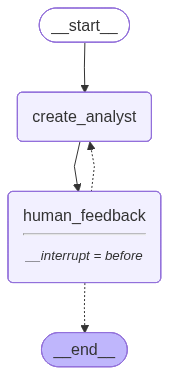

In [35]:
graph

In [36]:
topic="the benefits of adopting Langgraph as an agent framework"

In [37]:
max_analysts=4

In [38]:
thread={"configurable":{"thread_id":1}}

In [39]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Maya Patel
Affiliation: Institute for Scalable Systems (ISS)
Role: Performance & Scalability Analyst
Description: Focuses on the technical performance, concurrency handling, and scalability of Langgraph. Evaluates latency, throughput, resource utilization, and compares against alternative agent frameworks. Concerned with how Langgraph's graph-based execution model impacts large-scale deployments.
--------------------------------------------------
Name: Alex Chen
Affiliation: OpenAI Developer Relations
Role: Developer Experience Analyst
Description: Examines developer productivity, learning curve, and usability of Langgraph. Reviews documentation, SDK ergonomics, debugging tools, and community support. Motivated to assess how quickly teams can prototype and maintain complex agent workflows.
--------------------------------------------------
Name: Sofia García
Affiliation: Enterprise Integration Lab, TechBridge Corp.
Role: Ecosystem & Integration Analyst
Description: Analyzes L

In [40]:
state= graph.get_state(thread)

In [41]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Maya Patel', role='Performance & Scalability Analyst', affiliation='Institute for Scalable Systems (ISS)', description="Focuses on the technical performance, concurrency handling, and scalability of Langgraph. Evaluates latency, throughput, resource utilization, and compares against alternative agent frameworks. Concerned with how Langgraph's graph-based execution model impacts large-scale deployments."), Analyst(name='Alex Chen', role='Developer Experience Analyst', affiliation='OpenAI Developer Relations', description='Examines developer productivity, learning curve, and usability of Langgraph. Reviews documentation, SDK ergonomics, debugging tools, and community support. Motivated to assess how quickly teams can prototype and maintain complex agent workflows.'), Analyst(name='Sofia García', role='Ecosystem & Integration Analyst', affiliation='E

In [42]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Dr. Maya Patel', role='Performance & Scalability Analyst', affiliation='Institute for Scalable Systems (ISS)', description="Focuses on the technical performance, concurrency handling, and scalability of Langgraph. Evaluates latency, throughput, resource utilization, and compares against alternative agent frameworks. Concerned with how Langgraph's graph-based execution model impacts large-scale deployments."),
  Analyst(name='Alex Chen', role='Developer Experience Analyst', affiliation='OpenAI Developer Relations', description='Examines developer productivity, learning curve, and usability of Langgraph. Reviews documentation, SDK ergonomics, debugging tools, and community support. Motivated to assess how quickly teams can prototype and maintain complex agent workflows.'),
  Analyst(name='Sofia García', role='Ecosystem & Integration Analyst', affiliation='Enterprise Integ

In [43]:
state.next

('human_feedback',)

In [44]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0d9d76-612d-6ae9-bfff-5862030160de': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-12-15T16:59:20.219312+00:00\xa2id\xd9$1f0d9d76-612d-6ae9-bfff-5862030160de\xb0channel_versions\x81\xa9__start__\xd9300000000000000000000000000000001.0.4278191650157184\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0d9d76-612d-6aea-8000-2e0ed5d1006c': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-12-15T16:59:20.219312+00:00\xa2id\xd9$1f0d9d76-612d-6aea-8000-2e0ed5d1006c\xb0channel_versions\x84\xa9__start__\xd9300000000000000000000000000000002.0.9995701364763726\xa5topic\xd9300000000000000000000000000000002.0.9995701364763726\xacmax_analysts\xd9300000000000000000000000000000002.0.9995701364763726\xb8branch:to:create_analyst\xd9300000000000000000000000000000002.0.9995701364763726\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\xd

In [45]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d9d76-71e5-6f73-8001-9ec2303e976a'}}

In [46]:
graph.update_state(thread,
                   {"human_analyst_feedback": "Add something from the startup perspective and focus on the lastest enterprise application"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d9d76-b389-62d2-8002-604bf3895ad5'}}

In [47]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Maya Patel
Affiliation: Institute for Scalable Systems (ISS)
Role: Performance & Scalability Analyst
Description: Focuses on the technical performance, concurrency handling, and scalability of Langgraph. Evaluates latency, throughput, resource utilization, and compares against alternative agent frameworks. Concerned with how Langgraph's graph-based execution model impacts large-scale deployments.
--------------------------------------------------
Name: Alex Chen
Affiliation: OpenAI Developer Relations
Role: Developer Experience Analyst
Description: Examines developer productivity, learning curve, and usability of Langgraph. Reviews documentation, SDK ergonomics, debugging tools, and community support. Motivated to assess how quickly teams can prototype and maintain complex agent workflows.
--------------------------------------------------
Name: Sofia García
Affiliation: Enterprise Integration Lab, TechBridge Corp.
Role: Ecosystem & Integration Analyst
Description: Analyzes L

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Maya Patel
Affiliation: GlobalTech Solutions (Enterprise AI Division)
Role: Enterprise Scalability Analyst
Description: Focuses on how Langgraph handles large-scale, high-throughput workloads, fault tolerance, and performance optimization in mission-critical enterprise environments. Concerned with latency, resource management, and compliance.
--------------------------------------------------
Name: Liam Chen
Affiliation: LaunchPad AI (Seed-stage Startup Accelerator)
Role: Startup Innovation Analyst
Description: Evaluates Langgraph's rapid prototyping capabilities, low entry barriers, and flexibility for early-stage startups. Emphasizes speed to market, developer onboarding, and lean resource usage.
--------------------------------------------------
Name: Sofia Alvarez
Affiliation: IntegrateX Consulting (Enterprise Systems Integration)
Role: Enterprise Integration Specialist
Description: Examines Langgraph's ability to plug into existing enterprise data pipelines, legacy syste

In [48]:
state= graph.get_state(thread)

In [49]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'Add something from the startup perspective and focus on the lastest enterprise application', 'analysts': [Analyst(name='Dr. Maya Patel', role='Enterprise Scalability Analyst', affiliation='GlobalTech Solutions (Enterprise AI Division)', description='Focuses on how Langgraph handles large-scale, high-throughput workloads, fault tolerance, and performance optimization in mission-critical enterprise environments. Concerned with latency, resource management, and compliance.'), Analyst(name='Liam Chen', role='Startup Innovation Analyst', affiliation='LaunchPad AI (Seed-stage Startup Accelerator)', description="Evaluates Langgraph's rapid prototyping capabilities, low entry barriers, and flexibility for early-stage startups. Emphasizes speed to market, developer onboarding, and lean resource usage."), Analyst(name='Sofia Alvarez', role='Enterprise Integrati

In [50]:
state.next

('human_feedback',)

In [51]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'Add something from the startup perspective and focus on the lastest enterprise application',
 'analysts': [Analyst(name='Dr. Maya Patel', role='Enterprise Scalability Analyst', affiliation='GlobalTech Solutions (Enterprise AI Division)', description='Focuses on how Langgraph handles large-scale, high-throughput workloads, fault tolerance, and performance optimization in mission-critical enterprise environments. Concerned with latency, resource management, and compliance.'),
  Analyst(name='Liam Chen', role='Startup Innovation Analyst', affiliation='LaunchPad AI (Seed-stage Startup Accelerator)', description="Evaluates Langgraph's rapid prototyping capabilities, low entry barriers, and flexibility for early-stage startups. Emphasizes speed to market, developer onboarding, and lean resource usage."),
  Analyst(name='Sofia Alvarez', role='Enterprise Integration Specialist'

In [52]:
# If we are satisfied, then simply supply no feedback
further_feedback=""

In [53]:
# 1. Get the latest state
state= graph.get_state(thread)

# 2. Use the exact config from that state (if already has thread_id, checkpoint_ns, checkpoint_id)
cfg= state.config

# 3. Update the feedback at the "human_feedback" node
#        Tip: if your TypedDict says 'human_analyst_feedback: str', prefer empty string "" over None
graph.update_state(cfg, {'human_analyst_feedback': ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d9d77-0d0b-6c3b-8006-854f983827b9'}}

In [54]:
# 4. Verify it moved to END
final_state= graph.get_state(thread)
print(final_state.next)

()


In [55]:
analysts

[Analyst(name='Dr. Maya Patel', role='Enterprise Scalability Analyst', affiliation='GlobalTech Solutions (Enterprise AI Division)', description='Focuses on how Langgraph handles large-scale, high-throughput workloads, fault tolerance, and performance optimization in mission-critical enterprise environments. Concerned with latency, resource management, and compliance.'),
 Analyst(name='Liam Chen', role='Startup Innovation Analyst', affiliation='LaunchPad AI (Seed-stage Startup Accelerator)', description="Evaluates Langgraph's rapid prototyping capabilities, low entry barriers, and flexibility for early-stage startups. Emphasizes speed to market, developer onboarding, and lean resource usage."),
 Analyst(name='Sofia Alvarez', role='Enterprise Integration Specialist', affiliation='IntegrateX Consulting (Enterprise Systems Integration)', description="Examines Langgraph's ability to plug into existing enterprise data pipelines, legacy systems, and security frameworks. Focuses on API compati

In [56]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Maya Patel
Affiliation: GlobalTech Solutions (Enterprise AI Division)
Role: Enterprise Scalability Analyst
Description: Focuses on how Langgraph handles large-scale, high-throughput workloads, fault tolerance, and performance optimization in mission-critical enterprise environments. Concerned with latency, resource management, and compliance.
--------------------------------------------------
Name: Liam Chen
Affiliation: LaunchPad AI (Seed-stage Startup Accelerator)
Role: Startup Innovation Analyst
Description: Evaluates Langgraph's rapid prototyping capabilities, low entry barriers, and flexibility for early-stage startups. Emphasizes speed to market, developer onboarding, and lean resource usage.
--------------------------------------------------
Name: Sofia Alvarez
Affiliation: IntegrateX Consulting (Enterprise Systems Integration)
Role: Enterprise Integration Specialist
Description: Examines Langgraph's ability to plug into existing enterprise data pipelines, legacy syste

In [57]:
from langchain_community.document_loaders import WikipediaLoader
docs= WikipediaLoader(query="AWS").load()
print(docs[0].page_content[:500])

c:\Users\birok\Python\LLMOPs\research-report-generation\venv\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\birok\Python\LLMOPs\research-report-generation\venv\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Amazon Web Services, Inc. (AWS) is a subsidiary of Amazon that provides on-demand cloud computing platforms and APIs to individuals, companies, and governments, on a metered, pay-as-you-go basis.
Clients often use this in combination with autoscaling (a process that allows a client to use more computing in times of high application usage, and then scale down to reduce costs when there is less traffic). These cloud computing web services provide various services related to networking, compute, st


In [58]:
from langchain_community.utilities import WikipediaAPIWrapper
wiki = WikipediaAPIWrapper(doc_content_chars_max=4000)
docs = wiki.run("The benefits of adopting LangGraph as an agentic framework")
print(docs)

Page: Semantic Web
Summary: The Semantic Web, sometimes known as Web 3.0, is an extension of the World Wide Web through standards set by the World Wide Web Consortium (W3C). The goal of the Semantic Web is to make Internet data machine-readable.
To enable the encoding of semantics with the data, technologies such as Resource Description Framework (RDF) and Web Ontology Language (OWL) are used. These technologies are used to formally represent metadata. For example, ontology can describe concepts, relationships between entities, and categories of things. These embedded semantics offer significant advantages such as reasoning over data and operating with heterogeneous data sources.
These standards promote common data formats and exchange protocols on the Web, fundamentally the RDF. According to the W3C, "The Semantic Web provides a common framework that allows data to be shared and reused across application, enterprise, and community boundaries." The Semantic Web is therefore regarded as

## Second Workflow

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [6]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key= os.getenv("TAVILY_API_KEY")

In [8]:
tavily_search= TavilySearchResults(tavily_api_key=tavily_api_key)

C:\Users\birok\AppData\Local\Temp\ipykernel_9136\2693776339.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search= TavilySearchResults(tavily_api_key=tavily_api_key)


In [9]:
tavily_search.invoke("langgraph")

[{'title': 'What is LangGraph? - GeeksforGeeks',
  'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
  'content': '# What is LangGraph?\n\nLast Updated : \n10 Oct, 2025\n\nSuggest changes\n\n1 Likes\n\nLangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows. At its core, LangGraph combines large language models (LLMs) with graph-based architectures allowing developers to map, organize and optimize how AI agents interact and make decisions. [...] LangSmith: LangSmith is a dedicated API for managing large language models (LLMs). Provides functions for initializing LLMs, creating conditional logic and optimizing performance. [...] Suggested Quiz\n\nEdit Quiz\n\n5 Questions\n\nWhat is LangGraph primarily used for in AI development?\n\n A\n\n  Fine-tuning LLM models\n B\n\n  Building and managing graph-based AI agent workflows\n C\n\n  Visualizing data embeddings\n D\n\n  Deploying models to produc

In [10]:
from langchain_community.document_loaders import WikipediaLoader
docs= WikipediaLoader(query="Langgraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


In [63]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int #Number turns of conversation
    context: Annotated[List, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for send() API

class SearchQuery(BaseModel):
    search_query: str= Field(None, description="search query for retrieval.")

In [11]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [60]:
print(analyst.persona)

Name: Raj Mehta
Role: Cost & Productivity Analyst
Affiliation: FinOps Labs (Financial Operations Research Group)
Description: Analyzes the cost efficiency, developer productivity gains, and ROI of adopting Langgraph across both startups and large enterprises. Looks at licensing, cloud spend, and team velocity.



In [61]:
question_instructions.format(goals= analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Raj Mehta\nRole: Cost & Productivity Analyst\nAffiliation: FinOps Labs (Financial Operations Research Group)\nDescription: Analyzes the cost efficiency, developer productivity gains, and ROI of adopting Langgraph across both startups and large enterprises. Looks at licensing, cloud spend, and team velocity.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you so much fo

In [64]:
def generation_question(state: InterviewState):
    """Node to generate the questions"""

    #get state
    analyst=state["analyst"]
    messages= state["messages"]

    #generate the question
    system_message= question_instructions.format(goals=analyst.persona)
    question= llm.invoke([SystemMessage(content=system_message)]+messages)

    #Return the question state
    return {"messages":[question]}

In [65]:
analyst

Analyst(name='Raj Mehta', role='Cost & Productivity Analyst', affiliation='FinOps Labs (Financial Operations Research Group)', description='Analyzes the cost efficiency, developer productivity gains, and ROI of adopting Langgraph across both startups and large enterprises. Looks at licensing, cloud spend, and team velocity.')

In [66]:
state= {"max_num_turns":2, "context":[], "analyst":analyst, "interview":"", "section":[], "messages":[HumanMessage(content="Please do the proper search according to the expertise.")]}

In [67]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Raj Mehta', role='Cost & Productivity Analyst', affiliation='FinOps Labs (Financial Operations Research Group)', description='Analyzes the cost efficiency, developer productivity gains, and ROI of adopting Langgraph across both startups and large enterprises. Looks at licensing, cloud spend, and team velocity.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='Please do the proper search according to the expertise.', additional_kwargs={}, response_metadata={})]}

In [68]:
result= generation_question(state)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [70]:
print(result["messages"][0].content)

**Alex Patel – Analyst, Tech‑Productivity Insights**  

Hi Raj, thanks for taking the time to chat. I’m digging into how organizations are measuring the cost‑efficiency and productivity impact of Langgraph, and I’d love to hear about the concrete work you’ve been doing at FinOps Labs.

**1. Could you walk me through a recent case study (startup or enterprise) where you quantified the ROI of adopting Langgraph?**  
Specifically, I’m interested in:

- The baseline metrics you captured before Langgraph was introduced (e.g., cloud spend, developer‑hour cost, cycle‑time).  
- The licensing model you used for Langgraph in that engagement (per‑seat, usage‑based, enterprise‑wide).  
- The “after” numbers you observed and how you translated those into a dollar ROI figure.  

Feel free to share any surprising cost‑savings or productivity gains that stood out.


In [78]:
from langchain_core.messages import get_buffer_string

In [ ]:
# Search query writing
search_instructions= SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [75]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [79]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],
         'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?")
         ]
}

In [80]:

result = search_web(state)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [81]:
print(result["context"][0])

<Document href="https://latenode.com/blog/ai-frameworks-technical-infrastructure/langgraph-multi-agent-orchestration/langgraph-multi-agent-systems-complete-tutorial-examples"/>
LangGraph is a framework enabling multiple AI agents to collaborate on complex tasks by dividing responsibilities into specialized roles. This approach improves task efficiency, error management, and resource allocation. By leveraging LangGraph, businesses can automate workflows like customer support, content creation, and data processing. For example, a customer service system might classify inquiries, retrieve relevant data, and craft responses using different agents, all working together
</Document>

---

<Document href="https://www.linkedin.com/pulse/understanding-langgraph-its-role-enterprise-agentic-aisystems-ehsan-rbbkf"/>
At its core, LangGraph allows developers to define and execute intelligent workflows using a graph-based model, where every computation or decision is represented as a node and the sequ

In [88]:
def search_wikipedia(state: InterviewState):
    """
    Retrieve data from wiki
    """
    # Extract topic directly from the last message
    last_message = state['messages'][-1].content if state['messages'] else ""
    
    # Use LLM to generate query as plain text
    query_prompt = f"{search_instructions}\n\nConversation: {last_message}\n\nGenerate only the search query:"
    response = llm.invoke(query_prompt)
    search_query_text = response.content.strip()
    
    print("*******************************")
    print(f"Search query: {search_query_text}")
    
    # Search
    search_docs = WikipediaLoader(query=search_query_text).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [89]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],
         'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?")
         ]
}

In [90]:
result= search_wikipedia(state)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
Search query: Langgraph definition and business significance for innovation and digital transformation strategies


In [92]:
answer_instructions = """You are an expert being interviewed by an analyst.
Here is analyst area of focus: {goals}.      
You goal is to answer a question posed by the interviewer.
To answer question, use this context:      
{context}
When answering questions, follow these guidelines:      
1. Use only the information provided in the context.        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
3. The context contain sources at the topic of each individual document.
4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].
5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:   
[1] assistant/docs/llama3_1.pdf, page 7   
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [93]:
def generate_answer(state: InterviewState):
    """
    Node to answer a question
    """
    # Get state
    analyst= state["analyst"]
    messages=state["messages"]
    context=state["context"]

    #Answer question
    system_message= answer_instructions.format(goals=analyst.persona, context=context)
    answer= llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from th expert
    answer.name="expert"

    #Append it to the state
    return {"messages": [answer]}

In [101]:
def route_messages(state: InterviewState, name:str="expert"):
    """Route between question and answer"""

    #Get messages
    messages=state["messages"]
    max_num_turns= state.get('max_num_turns', 2)

    # Check the number of expert answers
    num_responses= len(
        [m for m in messages if isinstance(m, AIMessage) and m.name==name]
    )

    # End if expert has answered more than the max turns
    if num_responses>= max_num_turns:
        return 'save_interview'
    
    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question=messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return "save_interview"
    
    return "ask_question"

In [94]:
def save_interview(state: InterviewState):
    """ Save Interviews"""
    # Get messages
    messages=state["messages"]

    # Convert interview to a string
    interview= get_buffer_string(messages)

    #Save to interviews key
    return {'interview': interview}

In [95]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [98]:
def write_section(state: InterviewState):
    """Node to answer a question"""

    #Get state
    interview=state["interview"]
    context=state["context"]
    analyst= state["analyst"]
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message= section_writer_instructions.format(focus=analyst.description)
    section= llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write this section: {context}")])

    # Append it to state
    return {"sections":[section.content]}

In [97]:
interview_builder= StateGraph(InterviewState)

In [99]:
interview_builder.add_node("ask_question", generation_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

In [102]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "generate_answer")
interview_builder.add_edge("search_wikipedia", "generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                                        route_messages,
                                        ["ask_question",
                                         "save_interview"])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

In [106]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")

In [116]:
# Get the mermaid syntax
mermaid_syntax = interview_graph.get_graph().draw_mermaid()
print(mermaid_syntax)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	ask_question(ask_question)
	search_web(search_web)
	search_wikipedia(search_wikipedia)
	generate_answer(generate_answer)
	save_interview(save_interview)
	write_section(write_section)
	__end__([<p>__end__</p>]):::last
	__start__ --> ask_question;
	ask_question --> search_web;
	ask_question --> search_wikipedia;
	generate_answer -.-> ask_question;
	generate_answer -.-> save_interview;
	save_interview --> write_section;
	search_web --> generate_answer;
	search_wikipedia --> generate_answer;
	write_section --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [118]:
analyst.persona

'Name: Raj Mehta\nRole: Cost & Productivity Analyst\nAffiliation: FinOps Labs (Financial Operations Research Group)\nDescription: Analyzes the cost efficiency, developer productivity gains, and ROI of adopting Langgraph across both startups and large enterprises. Looks at licensing, cloud spend, and team velocity.\n'

In [119]:
thread= {"configurable":{"thread_id": "1"}}

In [120]:
messages= [HumanMessage("So you said you were writing an article on Langchain?")]

In [121]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
Search query: startup case study switching from Langchain to Langgraph cost savings licensing fees cloud compute engineering hours


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
Search query: "LangGraph" AND ("cost efficiency" OR "productivity impact") AND ("licensing fees" OR "subscription cost") AND ("mid‑size startup" OR "Fortune 500") AND ("hidden costs" OR "support tier" OR "SLA add‑on") AND ("LLM token consumption" OR "token reduction") AND ("cloud compute spend" OR "CPU utilization" OR "GPU utilization") AND ("ROI" OR "return on investment") AND ("managed service" OR "self‑hosted") AND ("break‑even point")


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 30.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 25.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [122]:
from IPython.display import Markdown

In [123]:
Markdown(interview["sections"][0])

## LangGraph ROI: Turning Developer‑Hour Savings into Real‑World Cost Efficiency for Startups and Enterprises  

### Summary  
AI‑agent frameworks such as LangGraph promise faster product cycles, but the true business impact hinges on licensing, cloud spend, and the hidden operational load of running agents at scale.  

1. **Massive productivity gains** – Uber’s engineering team reported a **21,000‑hour reduction** after adopting “intentional tech transfer” and “super‑capable domain‑expert agents” built with LangGraph [1]. This translates to roughly **$2.5 M** in saved labor (assuming $120 / hour), a headline ROI that even large enterprises can replicate.  

2. **Hidden engineering costs** – Although LangGraph’s core library is MIT‑licensed and free to download, real‑world deployments routinely require **14+ weeks and $87 k** of developer effort for a modest e‑commerce support agent [2]. The bulk of the expense comes from debugging, state‑persistence, and cloud infrastructure rather than the software itself.  

3. **Operational overhead of self‑hosting** – Running LangGraph Server demands managed Redis/PostgreSQL clusters, logging pipelines, and custom scaling logic. Teams that attempted a DIY deployment found themselves spending **45‑48 % more operational time** than with a managed service, equating to **$78 k–$325 k / year** for a five‑engineer squad [5][6].  

4. **Managed platforms accelerate velocity** – LangChain’s “LangSmith Deployment” service (cloud, hybrid, or self‑hosted) bundles state management, streaming, and error handling, letting teams ship agents in days instead of months. Cisco’s Outshift platform reported a **10× productivity boost**, cutting CI/CD pipeline setup from a week to under an hour [4].  

5. **Cost‑structure comparison** – Open‑source stacks still incur LLM API fees (≈ $50–$200 / month for small projects, $500–$2 000 / month for medium workloads) [3]. Enterprise‑grade graph back‑ends (e.g., TigerGraph) add **thousands to tens of thousands** of dollars monthly for dedicated support [3]. Managed SaaS alternatives typically bundle these expenses into a predictable subscription, reducing surprise spend.  

6. **Strategic trade‑offs for startups vs. enterprises** – Startups benefit most from the **speed‑to‑market** of managed LangGraph services, avoiding the steep upfront engineering outlay. Large enterprises, while capable of absorbing operational complexity, often achieve higher ROI by off‑loading DevOps to a managed layer, freeing senior engineers to focus on domain‑specific agent logic and business outcomes.  

Overall, the data suggest that **the headline “free” label of LangGraph is misleading**; true cost efficiency emerges only when organizations pair the open‑source core with a managed hosting or platform layer that curtails hidden engineering and operational expenses. When this balance is struck, the dramatic developer‑hour savings reported by industry leaders become a tangible, repeatable ROI driver across both startups and Fortune‑500 firms.  

### Sources  
[1] https://www.linkedin.com/posts/langchain_how-uber-used-langgraph-to-build-ai-developer-activity-7338259737395781634-QJ5d  
[2] https://agentiveaiq.com/blog/is-langgraph-free-how-agentiveaiq-beats-open-source  
[3] https://www.leanware.co/insights/langchain-vs-tigergraph-comparison  
[4] https://blog.langchain.com/tag/case-studies/  
[5] https://community.latenode.com/t/understanding-langgraph-server-deployment-costs-and-self-hosting-options/33992  
[6] https://strapi.io/blog/self-hosting-vs-managed-hosting  
[7] https://fin.ai/research/cost-of-serving-llms/  
[8] https://www.qovery.com/blog/self-hosted-vs-fully-managed-hosting  
[9] https://www.langchain.com/pricing